# Capstone Assignment 20.1 — Initial Report & EDA
## Industry Growth Prediction (Classification)

**Goal:** predict whether a California industry will **grow (1)** or **decline (0)** in employment in the next year using historical EDD employment time-series.

**Dataset:** `data/EDD-Data.csv` (monthly employment counts by industry).

## 1. Setup

In [24]:

# Core
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score,
    RocCurveDisplay
)

pd.set_option("display.max_columns", 120)
plt.rcParams["figure.figsize"] = (12, 6)


## 2. Load Data

In [25]:

DATA_PATH = "EDD-Data.csv"
df_raw = pd.read_csv(DATA_PATH)
df_raw.columns = [c.strip() for c in df_raw.columns]

df_raw.shape, df_raw.head(3)


((286, 196),
    SORTORDER  BMYEAR  AREA INCLUDES  BREAKS  PNCO   SS-NAICS  \
 0          1    2024     0      NaN     NaN     1  00-000010   
 1          2    2024     0      NaN     NaN     1  00-000020   
 2          3    2024     0      NaN     NaN     1  00-000030   
 
                      TITLE      Jan-10      Feb-10      Mar-10      Apr-10  \
 0     Civilian Labor Force  18,305,700  18,378,100  18,407,000  18,364,800   
 1      Civilian Employment  15,925,100  16,021,100  16,047,700  16,137,000   
 2    Civilian Unemployment   2,380,600   2,357,000   2,359,300   2,227,800   
 
        May-10      Jun-10      Jul-10      Aug-10      Sep-10      Oct-10  \
 0  18,318,700  18,339,300  18,431,000  18,428,000  18,407,000  18,333,300   
 1  16,161,800  16,104,300  16,108,300  16,140,900  16,193,200  16,143,700   
 2   2,156,900   2,235,000   2,322,800   2,287,100   2,213,800   2,189,600   
 
        Nov-10      Dec-10      Jan-11      Feb-11      Mar-11      Apr-11  \
 0  18,363,000 

## 3. Basic Data Understanding
The file contains identifying columns (industry code and title) plus many monthly columns (e.g., `Jan-10`, `Feb-10`, ...).

In [3]:

# Identify month columns
month_cols = [c for c in df_raw.columns if re.match(r"^(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)-\d{2}$", c)]
id_cols = [c for c in df_raw.columns if c not in month_cols]

len(month_cols), id_cols[:15], month_cols[:5], month_cols[-5:]


(188,
 ['SORTORDER',
  'BMYEAR',
  'AREA',
  'INCLUDES',
  'BREAKS',
  'PNCO',
  'SS-NAICS',
  'TITLE'],
 ['Jan-10', 'Feb-10', 'Mar-10', 'Apr-10', 'May-10'],
 ['Apr-25', 'May-25', 'Jun-25', 'Jul-25', 'Aug-25'])

## 4. Cleaning
Steps:
- Remove duplicate rows
- Convert monthly values to numeric (strip commas)
- Drop non-employment percentage rows (e.g., unemployment rate)
- Keep rows that have usable numeric time-series
- Impute missing monthly values (median per row)


In [4]:

df = df_raw.copy()

# 4.1 Remove duplicates
df = df.drop_duplicates()

# 4.2 Convert monthly columns to numeric
def to_number(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # remove commas
    s = s.replace(",", "")
    # drop percent sign if present (kept as NaN to exclude these rows later)
    if s.endswith("%"):
        return np.nan
    try:
        return float(s)
    except ValueError:
        return np.nan

for c in month_cols:
    df[c] = df[c].map(to_number)

# 4.3 Remove obvious non-industry summary rows (labor force, unemployment, etc.)
bad_title_patterns = [
    r"Unemployment Rate",
    r"Civilian Labor Force",
    r"Civilian Employment",
    r"Civilian Unemployment"
]
mask_bad = df["TITLE"].astype(str).str.contains("|".join(bad_title_patterns), regex=True, na=False)
df = df.loc[~mask_bad].copy()

# 4.4 Keep rows with at least 80% non-null monthly values
non_null_ratio = df[month_cols].notna().mean(axis=1)
df = df.loc[non_null_ratio >= 0.80].copy()

# 4.5 Impute missing monthly values per row using median of that row
row_medians = df[month_cols].median(axis=1, skipna=True)
df[month_cols] = df[month_cols].T.fillna(row_medians).T

df.shape, df[["SS-NAICS", "TITLE"]].head(5)


((282, 196),
     SS-NAICS                  TITLE
 4  01-000000  Total, All Industries
 5  11-000000             Total Farm
 6  00-000000          Total Nonfarm
 7  05-000000          Total Private
 8  06-000000        Goods Producing)

## 5. Reshape to Time-Series Format
Convert wide monthly columns into a long table: one row per (industry, month).

In [5]:

df_long = df.melt(
    id_vars=["SS-NAICS", "TITLE"],
    value_vars=month_cols,
    var_name="month",
    value_name="employment"
)

# Parse month column like 'Jan-10' into a real datetime
df_long["date"] = pd.to_datetime(df_long["month"], format="%b-%y")
df_long["year"] = df_long["date"].dt.year

df_long = df_long.drop(columns=["month"])
df_long = df_long.dropna(subset=["employment"])

df_long.shape, df_long.head(5)


((53016, 5),
     SS-NAICS                  TITLE  employment       date  year
 0  01-000000  Total, All Industries  14350700.0 2010-01-01  2010
 1  11-000000             Total Farm    301900.0 2010-01-01  2010
 2  00-000000          Total Nonfarm  14048800.0 2010-01-01  2010
 3  05-000000          Total Private  11604600.0 2010-01-01  2010
 4  06-000000        Goods Producing   1799200.0 2010-01-01  2010)

## 6. Annual Aggregation
Aggregate monthly employment to an annual average per industry.

In [6]:

df_year = (
    df_long.groupby(["SS-NAICS", "TITLE", "year"], as_index=False)
           .agg(employment_avg=("employment", "mean"),
                employment_min=("employment", "min"),
                employment_max=("employment", "max"),
                months=("employment", "size"))
)

# Keep years with at least 10 months present (should already be mostly complete)
df_year = df_year[df_year["months"] >= 10].copy()
df_year = df_year.sort_values(["SS-NAICS", "year"])

df_year.shape, df_year.head(8)


((4230, 7),
     SS-NAICS            TITLE  year  employment_avg  employment_min  \
 0  00-000000    Total Nonfarm  2010    1.428332e+07      14048800.0   
 1  00-000000    Total Nonfarm  2011    1.443483e+07      14197900.0   
 2  00-000000    Total Nonfarm  2012    1.476171e+07      14435100.0   
 3  00-000000    Total Nonfarm  2013    1.515104e+07      14796100.0   
 4  00-000000    Total Nonfarm  2014    1.557575e+07      15228900.0   
 5  00-000000    Total Nonfarm  2015    1.605147e+07      15661600.0   
 6  00-000000    Total Nonfarm  2016    1.647979e+07      16150100.0   
 7  00-000000    Total Nonfarm  2017    1.682656e+07      16462000.0   
 
    employment_max  months  
 0      14494400.0      12  
 1      14678300.0      12  
 2      15084700.0      12  
 3      15498200.0      12  
 4      15938900.0      12  
 5      16447300.0      12  
 6      16792700.0      12  
 7      17175800.0      12  )

## 7. Target Variable (Classification Label)
**GrowthLabel** is defined per (industry, year):
- `1` if next year's annual average employment is greater than the current year's
- `0` otherwise


In [7]:

df_year["employment_next_year"] = df_year.groupby("SS-NAICS")["employment_avg"].shift(-1)

df_year["GrowthLabel"] = (df_year["employment_next_year"] > df_year["employment_avg"]).astype(int)

# Remove last year for each industry (no next-year label)
df_model_base = df_year.dropna(subset=["employment_next_year"]).copy()

df_model_base[["SS-NAICS", "TITLE", "year", "employment_avg", "employment_next_year", "GrowthLabel"]].head(10)


,SS-NAICS,TITLE,year,employment_avg,employment_next_year,GrowthLabel
0,00-000000,Total Nonfarm,2010,1.428332e+07,1.443483e+07,1
1,00-000000,Total Nonfarm,2011,1.443483e+07,1.476171e+07,1
2,00-000000,Total Nonfarm,2012,1.476171e+07,1.515104e+07,1
3,00-000000,Total Nonfarm,2013,1.515104e+07,1.557575e+07,1
4,00-000000,Total Nonfarm,2014,1.557575e+07,1.605147e+07,1
5,00-000000,Total Nonfarm,2015,1.605147e+07,1.647979e+07,1
6,00-000000,Total Nonfarm,2016,1.647979e+07,1.682656e+07,1
7,00-000000,Total Nonfarm,2017,1.682656e+07,1.717152e+07,1
8,00-000000,Total Nonfarm,2018,1.717152e+07,1.742992e+07,1
9,00-000000,Total Nonfarm,2019,1.742992e+07,1.618632e+07,0


## 8. Feature Engineering
Create predictive features using only information available up to the current year:
- Lag employment
- Year-over-year change and percent change
- Rolling means (3-year)
- Trend over last 3 years (simple slope)


In [8]:

df_fe = df_model_base.copy()

# Lag features
df_fe["employment_lag1"] = df_fe.groupby("SS-NAICS")["employment_avg"].shift(1)

# YoY absolute and percent change (based on current vs prior year)
df_fe["yoy_change"] = df_fe["employment_avg"] - df_fe["employment_lag1"]
df_fe["yoy_pct"] = df_fe["yoy_change"] / df_fe["employment_lag1"]

# Rolling means (use past values including current year)
df_fe["roll3_mean"] = (
    df_fe.groupby("SS-NAICS")["employment_avg"]
         .rolling(window=3, min_periods=1).mean()
         .reset_index(level=0, drop=True)
)

# Trend slope over last 3 years (simple least squares on index 0..k-1)
def slope_last_k(x, k=3):
    x = x.values[-k:]
    if len(x) < 2:
        return np.nan
    t = np.arange(len(x))
    # slope = cov(t,x)/var(t)
    return np.cov(t, x, bias=True)[0, 1] / np.var(t)

df_fe["trend3_slope"] = (
    df_fe.groupby("SS-NAICS")["employment_avg"]
         .rolling(window=3, min_periods=2)
         .apply(lambda s: slope_last_k(s, 3), raw=False)
         .reset_index(level=0, drop=True)
)

# Log transform (helps scale large industries)
df_fe["log_employment"] = np.log1p(df_fe["employment_avg"])

# Remove rows where lag1 isn't available (needed for yoy features)
df_fe = df_fe.dropna(subset=["employment_lag1"]).copy()

df_fe.shape, df_fe.head(8)


((3666, 15),
     SS-NAICS            TITLE  year  employment_avg  employment_min  \
 1  00-000000    Total Nonfarm  2011    1.443483e+07      14197900.0   
 2  00-000000    Total Nonfarm  2012    1.476171e+07      14435100.0   
 3  00-000000    Total Nonfarm  2013    1.515104e+07      14796100.0   
 4  00-000000    Total Nonfarm  2014    1.557575e+07      15228900.0   
 5  00-000000    Total Nonfarm  2015    1.605147e+07      15661600.0   
 6  00-000000    Total Nonfarm  2016    1.647979e+07      16150100.0   
 7  00-000000    Total Nonfarm  2017    1.682656e+07      16462000.0   
 8  00-000000    Total Nonfarm  2018    1.717152e+07      16867400.0   
 
    employment_max  months  employment_next_year  GrowthLabel  employment_lag1  \
 1      14678300.0      12          1.476171e+07            1     1.428332e+07   
 2      15084700.0      12          1.515104e+07            1     1.443483e+07   
 3      15498200.0      12          1.557575e+07            1     1.476171e+07   
 4      1

## 9. Exploratory Data Analysis (EDA)
### 9.1 Target Distribution

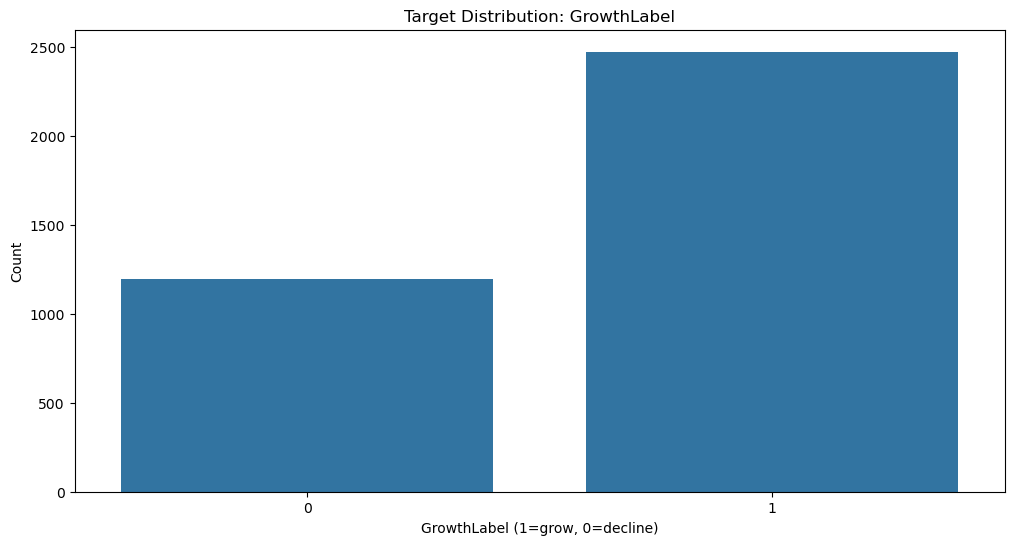

GrowthLabel
1    0.674032
0    0.325968
Name: proportion, dtype: float64

In [9]:

ax = sns.countplot(data=df_fe, x="GrowthLabel")
ax.set_title("Target Distribution: GrowthLabel")
ax.set_xlabel("GrowthLabel (1=grow, 0=decline)")
ax.set_ylabel("Count")
plt.show()

df_fe["GrowthLabel"].value_counts(normalize=True)


### 9.2 Employment Distribution (Continuous)
Histogram + boxplot to inspect skew and potential outliers.

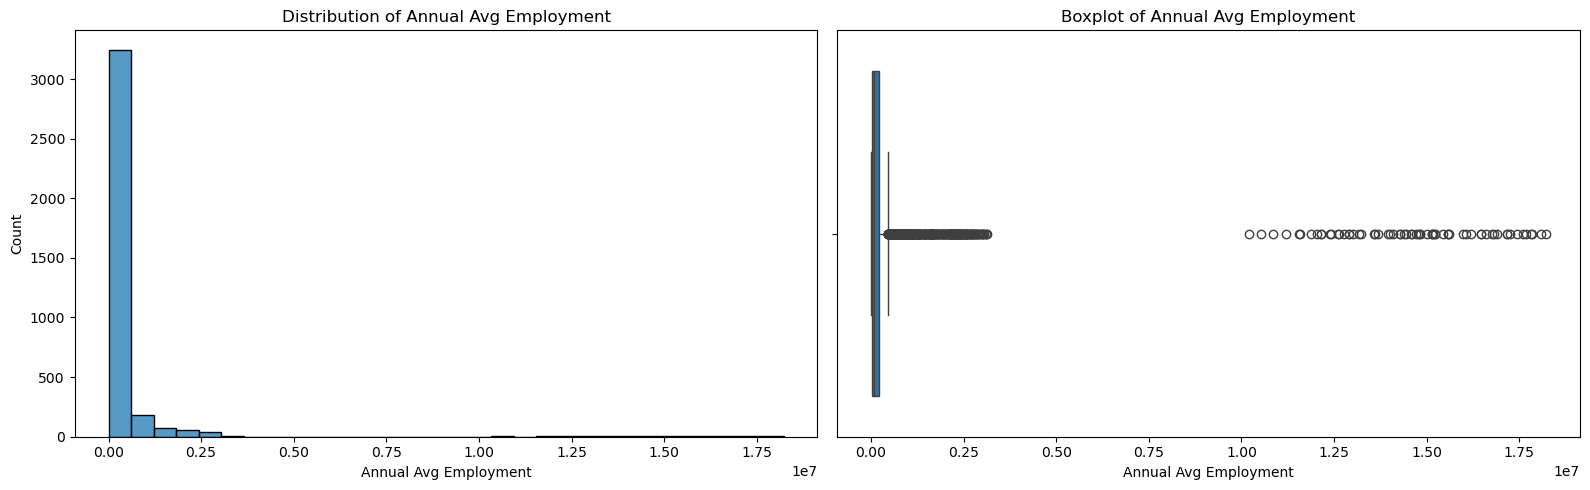

In [10]:

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(df_fe["employment_avg"], bins=30, ax=ax[0])
ax[0].set_title("Distribution of Annual Avg Employment")
ax[0].set_xlabel("Annual Avg Employment")

sns.boxplot(x=df_fe["employment_avg"], ax=ax[1])
ax[1].set_title("Boxplot of Annual Avg Employment")
ax[1].set_xlabel("Annual Avg Employment")

plt.tight_layout()
plt.show()


### 9.3 Outlier Analysis (IQR)
Identify extreme values in `employment_avg` using the IQR rule.

In [11]:

q1 = df_fe["employment_avg"].quantile(0.25)
q3 = df_fe["employment_avg"].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = df_fe[(df_fe["employment_avg"] < lower) | (df_fe["employment_avg"] > upper)]
(lower, upper, outliers.shape[0], outliers[["SS-NAICS","TITLE","year","employment_avg"]].sort_values("employment_avg", ascending=False).head(10))


(np.float64(-231932.29166666666),
 np.float64(462359.375),
 525,
      SS-NAICS                  TITLE  year  employment_avg
 29  01-000000  Total, All Industries  2023    1.822778e+07
 28  01-000000  Total, All Industries  2022    1.808826e+07
 25  01-000000  Total, All Industries  2019    1.785300e+07
 13  00-000000          Total Nonfarm  2023    1.782009e+07
 12  00-000000          Total Nonfarm  2022    1.767009e+07
 24  01-000000  Total, All Industries  2018    1.759372e+07
 9   00-000000          Total Nonfarm  2019    1.742992e+07
 23  01-000000  Total, All Industries  2017    1.724952e+07
 8   00-000000          Total Nonfarm  2018    1.717152e+07
 27  01-000000  Total, All Industries  2021    1.716021e+07)

### 9.4 Categorical Summary: Industries with Most Rows
Shows which industries have the most year records in the modeling dataset.

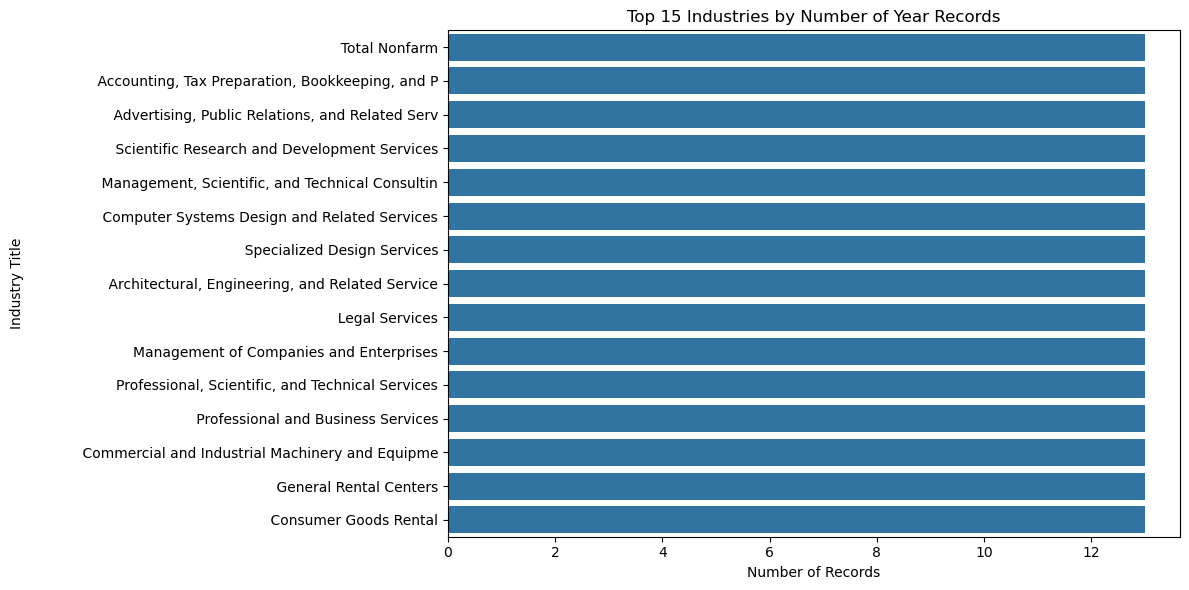

,SS-NAICS,TITLE,rows
0,00-000000,Total Nonfarm,13
185,60-541200,"Accounting, Tax Preparation, Bookk...",13
191,60-541800,"Advertising, Public Relations, and...",13
190,60-541700,Scientific Research and Developmen...,13
189,60-541600,"Management, Scientific, and Techni...",13
188,60-541500,Computer Systems Design and Relate...,13
187,60-541400,Specialized Design Services,13
186,60-541300,"Architectural, Engineering, and Re...",13
184,60-541100,Legal Services,13
193,60-550000,Management of Companies and Enterprises,13


In [12]:

top_industries = (
    df_fe.groupby(["SS-NAICS","TITLE"]).size().reset_index(name="rows")
         .sort_values("rows", ascending=False).head(15)
)

plt.figure(figsize=(12,6))
sns.barplot(data=top_industries, y="TITLE", x="rows")
plt.title("Top 15 Industries by Number of Year Records")
plt.xlabel("Number of Records")
plt.ylabel("Industry Title")
plt.tight_layout()
plt.show()

top_industries.head(10)


### 9.5 Trend Examples (Plotly)
Interactive line plot for a few example industries.

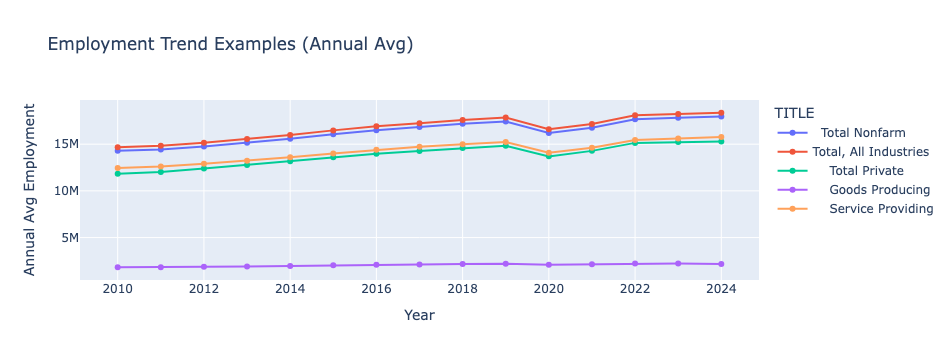

In [13]:

sample_codes = df_fe["SS-NAICS"].drop_duplicates().head(5).tolist()
df_plot = df_year[df_year["SS-NAICS"].isin(sample_codes)].copy()

fig = px.line(
    df_plot,
    x="year",
    y="employment_avg",
    color="TITLE",
    markers=True,
    title="Employment Trend Examples (Annual Avg)"
)
fig.update_layout(xaxis_title="Year", yaxis_title="Annual Avg Employment")
fig.show()


### 9.6 Correlation Heatmap (Engineered Numeric Features)

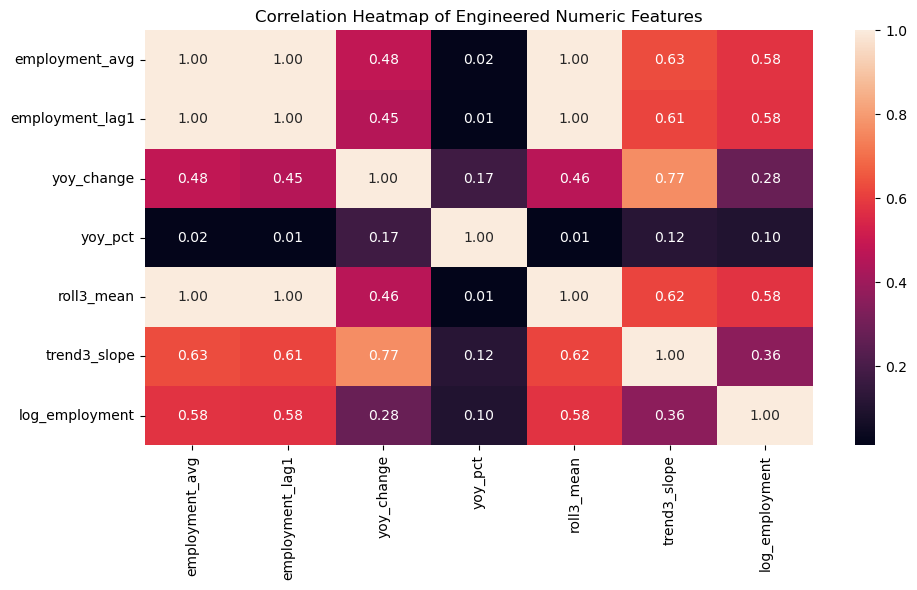

In [14]:

num_cols = ["employment_avg","employment_lag1","yoy_change","yoy_pct","roll3_mean","trend3_slope","log_employment"]
corr = df_fe[num_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Engineered Numeric Features")
plt.tight_layout()
plt.show()


## 10. Baseline Model (Logistic Regression)
### Rationale
- Binary classification target (grow vs decline)
- Interpretable baseline
- Works well with standardized numeric features and one-hot encoded categories

### Evaluation Metric
**F1-score** is used as the primary metric because it balances precision and recall, and is appropriate when class distributions may not be perfectly balanced.


In [15]:

# Define features and target
target = "GrowthLabel"
feature_cols = ["SS-NAICS", "year", "employment_avg", "employment_lag1", "yoy_change", "yoy_pct", "roll3_mean", "trend3_slope", "log_employment"]

df_model = df_fe[feature_cols + [target]].copy()

# Train/test split with time awareness:
# Use a cutoff year so test data is "future" relative to train (reduces leakage).
cutoff_year = int(df_model["year"].quantile(0.8))
train_df = df_model[df_model["year"] <= cutoff_year].copy()
test_df  = df_model[df_model["year"] > cutoff_year].copy()

X_train, y_train = train_df[feature_cols], train_df[target]
X_test, y_test   = test_df[feature_cols], test_df[target]

X_train.shape, X_test.shape, cutoff_year


((3102, 9), (564, 9), 2021)

In [16]:

# Preprocessing
categorical_features = ["SS-NAICS"]
numeric_features = [c for c in feature_cols if c not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Baseline model
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=200, class_weight="balanced"))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print("F1-score:", round(f1, 4))
print("ROC-AUC :", round(roc, 4))


F1-score: 0.5152
ROC-AUC : 0.6753


In [17]:

# Classification report
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.5831    0.7700    0.6637       287
           1     0.6432    0.4296    0.5152       277

    accuracy                         0.6028       564
   macro avg     0.6132    0.5998    0.5894       564
weighted avg     0.6126    0.6028    0.5907       564



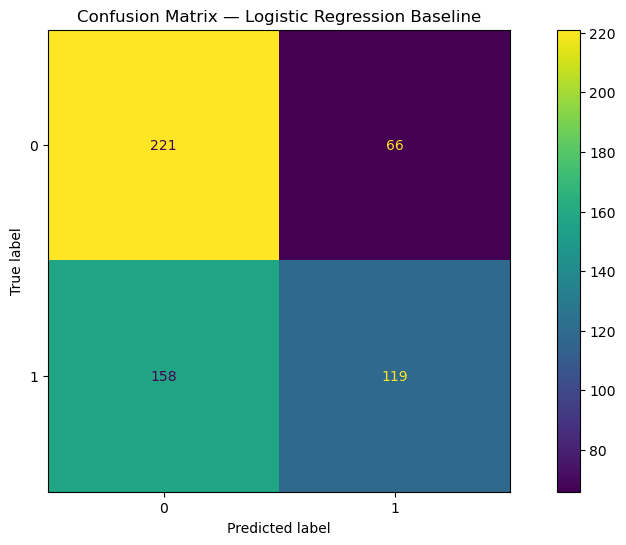

In [18]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix — Logistic Regression Baseline")
plt.show()


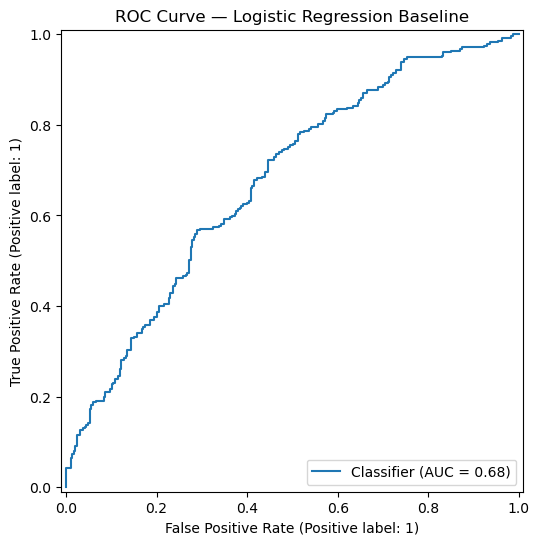

In [19]:

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve — Logistic Regression Baseline")
plt.show()


## 11. Summary of Findings (Initial)
- The dataset was cleaned (duplicates removed, numeric conversion, row filtering, and imputation).
- Monthly employment was aggregated to annual averages per industry.
- A binary target label (`GrowthLabel`) was created using next-year employment.
- Feature engineering added lag, YoY change, rolling averages, and trend slope.
- Baseline Logistic Regression was trained and evaluated using **F1-score** and ROC-AUC.

